In [1]:
!pip3 install pandas matplotlib

In [2]:
BASEDIR = "."

import pandas
juju_data = pandas.read_csv(
    BASEDIR + '/juju/benchmark.csv',
    sep=";",
    comment="#"
)

juju_data.head()


,model_name,num_consumers,action,event,start,end,elapsed
0,k8s-test-5,5,deploy,pods,1.556271e+09,1.556271e+09,71.297592
1,k8s-test-5,5,deploy,juju,1.556271e+09,1.556271e+09,77.424011
2,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,16.107294
3,k8s-test-5,5,change,juju,1.556271e+09,1.556271e+09,44.193782
4,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,19.313293


In [3]:
import pandas
k8s_data = pandas.read_csv(
    BASEDIR + '/k8s/benchmark.csv',
    sep=";",
    comment="#"
)

k8s_data = k8s_data[k8s_data.num_consumers < 60]

k8s_data.tail()


,namespace,num_consumers,action,event,start,end,elapsed
237,k8s-native-test,55,change,settled,1.616534e+09,1.616534e+09,33.601036
238,k8s-native-test,55,change,pods,1.616534e+09,1.616534e+09,16.262702
239,k8s-native-test,55,change,settled,1.616534e+09,1.616534e+09,32.796125
240,k8s-native-test,55,change,pods,1.616534e+09,1.616534e+09,23.420440
241,k8s-native-test,55,change,settled,1.616534e+09,1.616534e+09,35.392207


In [4]:
import pandas
orcon_data = pandas.read_csv(
    BASEDIR + '/orcon/benchmark.csv',
    sep=";",
    comment="#"
)


# orcon_data[orcon_data["num_consumers"] == 20].head(n=20)
orcon_data.head(50)


,namespace,num_consumers,action,event,start,end,elapsed
0,k8s-orcon-test,5,deploy,pods,1.557919e+09,1.557919e+09,9.528767
1,k8s-orcon-test,5,deploy,settled,1.557919e+09,1.557919e+09,17.969216
2,k8s-orcon-test,5,change,pods,1.557919e+09,1.557919e+09,8.472860
3,k8s-orcon-test,5,change,settled,1.557919e+09,1.557919e+09,9.854065
4,k8s-orcon-test,5,change,pods,1.557919e+09,1.557919e+09,7.318443
5,k8s-orcon-test,5,change,settled,1.557919e+09,1.557919e+09,9.892720
6,k8s-orcon-test,5,change,pods,1.557919e+09,1.557919e+09,8.508615
7,k8s-orcon-test,5,change,settled,1.557919e+09,1.557919e+09,15.935996
8,k8s-orcon-test,5,change,pods,1.557919e+09,1.557919e+09,7.479999
9,k8s-orcon-test,5,change,settled,1.557919e+09,1.557919e+09,10.054500


In [5]:
import pandas
orcon_no_initc_data = pandas.read_csv(
    BASEDIR + '/orcon/benchmark-deployments-no-initc.csv',
    sep=";",
    comment="#"
)


orcon_no_initc_data.head()

,namespace,num_consumers,action,event,start,end,elapsed
0,k8s-orcon-test,5,deploy,pods,1.557913e+09,1.557913e+09,4.865822
1,k8s-orcon-test,5,deploy,settled,1.557913e+09,1.557913e+09,15.760463
2,k8s-orcon-test,5,change,pods,1.557913e+09,1.557913e+09,3.718876
3,k8s-orcon-test,5,change,settled,1.557913e+09,1.557913e+09,9.853581
4,k8s-orcon-test,5,change,pods,1.557913e+09,1.557913e+09,3.979202


In [6]:
import pandas
helm_data = pandas.read_csv(
    BASEDIR + '/helm/benchmark.csv',
    sep=";",
    comment="#"
)


helm_data.tail(50)

,namespace,num_consumers,action,event,start,end,elapsed
236,default,45,change,pods,1.615826e+09,1.615826e+09,16.735620
237,default,45,change,settled,1.615826e+09,1.615826e+09,22.838164
238,default,45,change,pods,1.615826e+09,1.615826e+09,16.101383
239,default,45,change,settled,1.615826e+09,1.615826e+09,23.799088
240,default,45,change,pods,1.615826e+09,1.615826e+09,17.593247
241,default,45,change,settled,1.615826e+09,1.615826e+09,22.251573
242,default,50,deploy,pods,1.615826e+09,1.615826e+09,16.151124
243,default,50,deploy,settled,1.615826e+09,1.615826e+09,16.833388
244,default,50,change,pods,1.615826e+09,1.615826e+09,15.078612
245,default,50,change,settled,1.615826e+09,1.615826e+09,24.396382


In [7]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import math

def create_sane_figure():
    # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    fig = plt.figure(figsize=(10, 6))  # a new figure window
    ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

    # Put the axis behind the datapoints
    ax.set_axisbelow(True)
    # Grey ticks, labels, and axis'
    for spine in ax.spines.values():
        spine.set_color('black')
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_color('black')
    ax.set_xlabel(None, fontsize=16, color='black')
    ax.set_ylabel(None, fontsize=16, color='black')
    # Don't show a grid
    ax.grid(False)
    # remove top and right border of graph
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(
        axis='both', which='both',
        labelsize=14, labelcolor='black',
        color='black')
    # Make the title big enough so it spans the entire plot, but don't make it
    # so big that it requires two lines to show.
    ax.set_title(None, fontsize=22, color='black')
    return (fig, ax)

<ipython-input-8-acf51b298fa4>:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


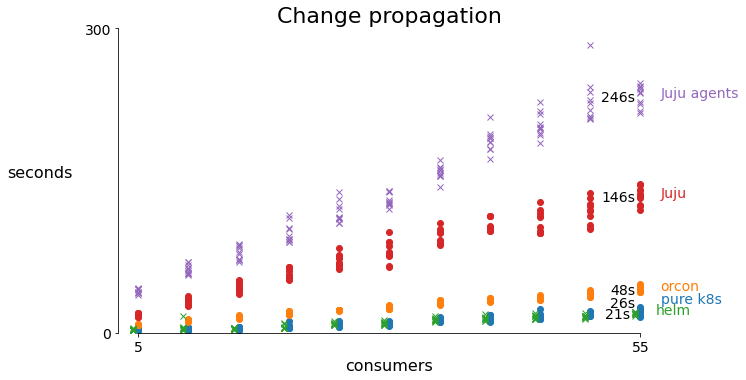

In [8]:
%matplotlib inline

changedatap_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "pods")]
changedataj_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "juju")]
deploydatap_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "pods")]
deploydataj_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "juju")]
changedata_k8s = k8s_data[(k8s_data["action"]=="change") & (k8s_data['event'] == "pods")]
changedata_orcon = orcon_data[(orcon_data["action"]=="change") & (orcon_data['event'] == "pods")]
changedata_helm = helm_data[(helm_data["action"]=="change") & (helm_data['event'] == "pods")]

def create_multiple_soy_clusters():
    (fig, ax) = create_sane_figure()
    fig.set_size_inches(9, 5.6)

    ax.set_title("Change propagation", fontsize=22)
    ax.set_xlabel("consumers")
    ax.set_yticks([0,300])
    ax.set_ylabel("""seconds""", rotation='horizontal', labelpad=45)
#     ax.set_ylabel('abc', rotation=0, fontsize=20, labelpad=20)
#     plt.margins(4)
#     ax.set_yticklabels(["0 minutes", "5 minutes"])

    pods_k8s_plot = ax.plot(
        changedata_k8s['num_consumers'], changedata_k8s['elapsed'],'o',
        clip_on=False,
    )
    pods_orcon_plot = ax.plot(
        changedata_orcon['num_consumers'], changedata_orcon['elapsed'],'o',
        clip_on=False,
    )
    pods_helm_plot = ax.plot(
        changedata_helm['num_consumers']-0.5, changedata_helm['elapsed'],'x',
        clip_on=False,
    )
    pods_juju_plot = ax.plot(
        changedatap_juju['num_consumers'], changedatap_juju['elapsed'],'o',
        clip_on=False,
    )
    agents_plot = ax.plot(
        changedataj_juju['num_consumers'], changedataj_juju['elapsed'],'x',
        clip_on=False,
    )
  
    
    
    xs = []
    [xs.extend(l.get_xdata()) for l in ax.lines]
    xmax = max(xs)
    xmin = math.ceil(min(xs))
    
    import statistics
    
    plt.text(
        xmax+2,
        statistics.mean(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])-1.20,
        'Juju',
        fontsize=14,
        color=pods_juju_plot[0].get_color())
    plt.text(
        xmax+2,
        statistics.mean(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed'])-1.20,
        """Juju agents""",
        fontsize=14,
        color=agents_plot[0].get_color())
    plt.text(
        xmax+2,
        statistics.mean(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])-1.20+10.80,
        'pure k8s',
        fontsize=14,
        color=pods_k8s_plot[0].get_color())
    plt.text(
        xmax+2,
        statistics.mean(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed'])-1.20,
        'orcon',
        fontsize=14,
        color=pods_orcon_plot[0].get_color())
    plt.text(
        xmax+2-0.5,
        statistics.mean(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed'])-1.20,
        'helm',
        fontsize=14,
        color=pods_helm_plot[0].get_color())
    
    ax.annotate(
        '{}s'.format(round(max(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed']))),
        (xmax-0.5, statistics.mean(changedatap_juju[changedatap_juju['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed']))),
        (xmax-0.5, statistics.mean(changedataj_juju[changedataj_juju['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed']))),
        (xmax-0.5, statistics.mean(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])-1.20+10.80),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed']))),
        (xmax-0.5, statistics.mean(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed']))),
        (xmax-1, statistics.mean(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)   
    
    ax.set_xticks([xmin, xmax])

    
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=0, top=300)
    ax.spines['left'].set_position(('outward', 20))

    from matplotlib.transforms import Bbox

    
    # Save the plot to a file
    fig.savefig("base_url_propagation.pdf", bbox_inches=Bbox.from_bounds(-0.8, 0.1, 10.8, 5.2), dpi=300)
    fig.savefig("base_url_propagation.tiff", bbox_inches=Bbox.from_bounds(-0.8, 0.1, 10.8, 5.2), dpi=300)
    fig.show()
create_multiple_soy_clusters()

<ipython-input-9-2557aa73031d>:106: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


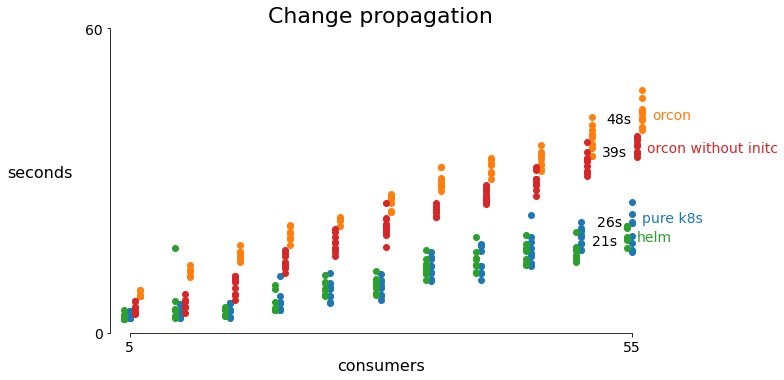

In [9]:
%matplotlib inline

changedata_k8s = k8s_data[(k8s_data["action"]=="change") & (k8s_data['event'] == "pods")]
changedata_orcon = orcon_data[(orcon_data["action"]=="change") & (orcon_data['event'] == "pods")]
changedata_orcon_no_initc = orcon_no_initc_data[(orcon_no_initc_data["action"]=="change") & (orcon_no_initc_data['event'] == "pods")]
changedata_helm = helm_data[(helm_data["action"]=="change") & (helm_data['event'] == "pods")]

def create_k8s_orcon():
    (fig, ax) = create_sane_figure()
    fig.set_size_inches(9, 5.6)

    ax.set_title("Change propagation", fontsize=22)
    ax.set_xlabel("consumers")
    ax.set_yticks([0,60])
    ax.set_ylabel("""seconds""", rotation='horizontal', labelpad=45)
#     ax.set_ylabel('abc', rotation=0, fontsize=20, labelpad=20)
#     plt.margins(4)
#     ax.set_yticklabels(["0 minutes", "5 minutes"])


    pods_k8s_plot = ax.plot(
        changedata_k8s['num_consumers'], changedata_k8s['elapsed'],'o',
        clip_on=False,
    )
    pods_orcon_plot = ax.plot(
        changedata_orcon['num_consumers']+1, changedata_orcon['elapsed'],'o',
        clip_on=False,
    )
    helm_plot = ax.plot(
        changedata_helm['num_consumers']-0.5, changedata_helm['elapsed'],'o',
        clip_on=False,
    )
    pods_orcon_no_initc_plot = ax.plot(
        changedata_orcon_no_initc['num_consumers']+0.5, changedata_orcon_no_initc['elapsed'],'o',
        clip_on=False,
    )

    
    xs = []
    [xs.extend(l.get_xdata()) for l in ax.lines]
    xmax = max(xs)-1
    xmin = math.ceil(min(xs))
    
    import statistics
    
    plt.text(
        xmax+1,
        statistics.mean(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])-1.20+3.0,
        'pure k8s',
        fontsize=14,
        color=pods_k8s_plot[0].get_color())
    plt.text(
        xmax+2,
        statistics.mean(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed'])-1.20,
        'orcon',
        fontsize=14,
        color=pods_orcon_plot[0].get_color())
    plt.text(
        xmax+1.5,
        statistics.mean(changedata_orcon_no_initc[changedata_orcon_no_initc['num_consumers'] == xmax]['elapsed'])-1.20,
        """orcon without initc""",
        fontsize=14,
        color=pods_orcon_no_initc_plot[0].get_color())
    plt.text(
        xmax+0.5,
        statistics.mean(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed'])-1.20,
        """helm""",
        fontsize=14,
        color=helm_plot[0].get_color())
    
    ax.annotate(
        '{}s'.format(round(max(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed']))),
        (xmax-1, statistics.mean(changedata_k8s[changedata_k8s['num_consumers'] == xmax]['elapsed'])-1.20+3.0),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed']))),
        (xmax, statistics.mean(changedata_orcon[changedata_orcon['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_orcon_no_initc[changedata_orcon['num_consumers'] == xmax]['elapsed']))),
        (xmax-0.5, statistics.mean(changedata_orcon_no_initc[changedata_orcon['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)
    ax.annotate(
        '{}s'.format(round(max(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed']))),
        (xmax-1.5, statistics.mean(changedata_helm[changedata_helm['num_consumers'] == xmax]['elapsed'])-1.20),
        ha='right', va='center',
        fontsize=14)        
    
    
    ax.set_xticks([xmin, xmax])

    
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=0, top=60)
    ax.spines['left'].set_position(('outward', 20))

    from matplotlib.transforms import Bbox
    
    # Save the plot to a file
#     fig.savefig("orcon.png", bbox_inches="tight")
    fig.savefig("initc_impact.pdf", bbox_inches=Bbox.from_bounds(-0.6, 0.1, 10.8, 5.2), dpi=300)
    fig.savefig("initc_impact.tiff", bbox_inches=Bbox.from_bounds(-0.6, 0.1, 10.8, 5.2), dpi=300)
    fig.show()
create_k8s_orcon()